In [1]:
import numpy as np
import pandas as pd
from graph_tool.all import *
import cairo
import configparser
import csv
config = configparser.ConfigParser()
a = config.read('config.ini')

In [2]:
# load delay calculate function
%run delay.ipynb
# load random event
%run random.ipynb

In [3]:
# class of node
class AbstractNode:
    def __init__(self, name, show_name, vertex, nid):
        self.name = name
        self.show_name = show_name
        self.vertex = vertex
        self.nid = nid
        self.x = 0.0
        self.y = 0.0
        self.links = []
        self.is_critical = 0
        
    def append_link(self,link):
        self.links.append(link)
        
        
class Node(AbstractNode):
    def __init__(self, nid, name, show_name, vertex, node_type, surface_url):
        super().__init__(name, show_name, vertex,nid)
        self.links = []
        self.type = node_type  
        self.surface_url = surface_url
        self.total_delay = 0.0
        
        
    def get_total_delay_format(self):
        return f"{self.total_delay:.2e}"
    
class DJNode(AbstractNode):
    def __init__(self, nid, name, show_name, vertex):
        super().__init__(name, show_name, vertex,nid)
        
class Label(AbstractNode):
    def __init__(self, name, show_name, vertex,main_node,x_off,y_off):
        super().__init__(name, show_name, vertex, main_node.x+float(x_off), main_node.y+float(y_off))


In [4]:
# class of edge
class AbstractEdge:
    def __init__(self, start_node, end_node, edge):
        self.start_node = start_node
        self.end_node = end_node
        self.edge = edge

class Link(AbstractEdge):
    def __init__(self, start_node, end_node, trans_bandwidth, prop_distance, dash, edge,loss_up,loss_down):
        super().__init__(start_node, end_node, edge)
        self.trans_bandwidth = trans_bandwidth
        self.prop_distance = prop_distance
        self.dash = dash
        self.loss_up = loss_up
        self.loss_down = loss_down
        self.delay_up = 0.0
        self.delay_down = 0.0
        self.is_used = 0
        
    def get_destance_format(self):
        return f'{float(self.prop_distance):.2f}Km'
        
    def get_band_format(self):
        return f'{float(self.trans_bandwidth):.0f}MB'
    
    def get_self_delay(self,transPackageSize):
        self.delay_up = networkMessageDelay(transPackageSize=transPackageSize,
                                         transBandWidth=self.trans_bandwidth,
                                         propagationDistance=self.prop_distance,
                                         propagationLoss=self.loss_up)
        self.delay_down = networkMessageDelay(transPackageSize=transPackageSize,
                                         transBandWidth=self.trans_bandwidth,
                                         propagationDistance=self.prop_distance,
                                         propagationLoss=self.loss_down)

class Route(AbstractEdge):
    def __init__(self, start_node, end_node, edge):
        super().__init__(start_node, end_node, edge)


class DJLink(AbstractEdge):
    def __init__(self, start_node, end_node, edge,delay):
        super().__init__(start_node, end_node, edge)
        self.delay = delay
        

In [5]:
# functions
def milli_to_micro(time):
    return time * 1000

def find_node_by_name(nodes,name):
    for node in nodes:
        if node.name == name:
            return node
    return None

def find_node_by_id(nodes,nid):
    for node in nodes:
        if node.nid == nid:
            return node
    return None

def is_linked(links,start_node,end_node):
    for link in links:
        if (link.start_node == start_node and link.end_node == end_node) or (link.start_node == end_node and link.end_node == start_node):
            return True
    return False

def find_link_by_nodes_name(links,name1,name2):
    for link in links:
        if (link.start_node.name, link.end_node.name) in [(name1, name2), (name2, name1)]:
            return link
    return None

def find_link_by_nodes(links,node1,node2):
    for link in links:
        if (link.start_node, link.end_node) in [(node1, node2), (node2, node1)]:
            return link
    return None

def find_node_by_vertex(nodes,vertex):
    for node in nodes:
        if node.vertex == vertex:
            return node
    return None

def add_new_link(nodes,start_node, end_node, trans_bandwidth, prop_distance, dash):
    if (start_node is None) or (end_node is None):
        return
    new_edge = g.add_edge(start_node.vertex,end_node.vertex)
    new_link = Link(start_node=start_node
                    ,end_node=end_node
                    ,trans_bandwidth=trans_bandwidth
                    ,prop_distance=prop_distance
                    ,dash=dash
                    ,edge=new_edge
                    )
    return new_link

def get_distance_auto(device1, device2):
    if device1 == "Clock" and device2 == "WifiRouter":
        return np.round(np.random.uniform(0.1, 1.0), 2)
    if device1 == "WifiRouter" and device2 == "MainRouter":
        return np.round(np.random.uniform(0.1, 1.0), 2)
    elif device1 == "MainRouter" and device2 == "MainRouter":
        return np.round(np.random.uniform(1, 1000), 2)
    else:
        return np.round(np.random.uniform(1, 10), 2)

def get_bandwidth_auto(device1, device2):
    if device1 == "Clock" and device2 == "WifiRouter":
        return np.random.choice(np.arange(128, 1025, 128))*1.0
    if device1 == "WifiRouter" and device2 == "MainRouter":
        return np.random.choice(np.arange(128, 1025, 128))*1.0
    elif device1 == "MainRouter" and device2 == "MainRouter":
        return np.random.choice(np.arange(1024, 10241, 128))*1.0
    else:
        return np.round(np.random.uniform(1, 10), 2)
    
def get_lost_auto(device1, device2):
    if device1 == "Clock" and device2 == "WifiRouter":
        return np.round(np.random.uniform(0.1, 0.2), 2)
    if device1 == "WifiRouter" and device2 == "MainRouter":
        return np.round(np.random.uniform(0.1, 0.2), 2)
    elif device1 == "MainRouter" and device2 == "MainRouter":
        return np.round(np.random.uniform(0.05, 0.1), 2)
    else:
        return np.round(np.random.uniform(1, 10), 2)

def add_new_link_auto(start_node, end_node, dash):
    if (start_node is None) or (end_node is None):
        return
    new_edge = g.add_edge(start_node.vertex,end_node.vertex)
    new_link = Link(start_node=start_node
                    ,end_node=end_node
                    ,trans_bandwidth=get_bandwidth_auto(start_node.type,end_node.type)
                    ,prop_distance=get_distance_auto(start_node.type,end_node.type)
                    ,dash=dash
                    ,edge=new_edge
                    ,loss_up=get_lost_auto(start_node.type,end_node.type)
                    ,loss_down=get_lost_auto(start_node.type,end_node.type)
                    )
    start_node.append_link(new_link)
    end_node.append_link(new_link)
    return new_link

def add_new_route(start_node, end_node):
    if (start_node is None) or (end_node is None):
        return
    new_edge = g.add_edge(start_node.vertex,end_node.vertex)
    new_link = Route(start_node=start_node
                    ,end_node=end_node
                    ,edge=new_edge)
    return new_link

def find_type_in_neighbor(node,target_type):
    res = 0
    for link in node.links:
        if(node != link.start_node):
            if(link.start_node.type == target_type):
                res+=1
        if(node != link.end_node):
            if(link.end_node.type == target_type):
                res+=1   
    return res

def get_delay_format(delay):
    return f'{delay:.2e}ms'

def get_delay_format_micros(delay):
    return f'{milli_to_micro(delay):.2f}µs'

def copy_Node_to_DJNode(node,dj_g):
    new_node = DJNode(nid=node.nid
                          ,name=node.name
                          ,show_name=node.show_name
                          ,vertex=dj_g.add_vertex()
                         )
#     new_node.is_critical = node.is_critical
    return new_node

def add_node_showname(g_v,node,addtional_label):
    g_v[node.vertex]=f"{node.show_name}{addtional_label}"

In [6]:
# basic var
# if this part changed, all cell below need restart 
nodes = []
links = []
routes = []
route_nodes_list = []
scene_path = config.get('config', 'scene_path')+"sim_auto/"
package_size = float(config.get('config', 'package_size'))
g = Graph(directed=False)
g_sfcs = g.new_vertex_property("object")
g_pos = g.new_vertex_property("vector<float>")
g_shape = g.new_vertex_property("string")
g_eorder = g.new_edge_property("int")

g_v_label = g.new_vertex_property("string")
g_v_size = g.new_vertex_property("double")
g_v_color = g.new_vertex_property("string")
g_v_fill_color = g.new_vertex_property("string")
g_v_pen_width = g.new_vertex_property("float")
g_v_halo = g.new_vertex_property("bool")
g_v_text_position = g.new_vertex_property("float")
g_v_text_offset = g.new_vertex_property("vector<int>")
g_v_font_size = g.new_vertex_property("int")
g_v_halo_color = g.new_vertex_property("string")
g_v_halo_size = g.new_vertex_property("float")

g_e_end_mark = g.new_edge_property("string")
g_e_start_mark = g.new_edge_property("string")
g_e_pen_width = g.new_edge_property("int")
g_e_marker_size = g.new_edge_property("int")
g_e_text = g.new_edge_property("string")
g_e_text_parallel = g.new_edge_property("bool")
g_e_text_font_size = g.new_edge_property("int")
g_e_color = g.new_edge_property("string")
g_e_text_distance = g.new_edge_property("float")
g_e_dash_style = g.new_edge_property("vector<float>")

In [7]:
# create nodes
# data = np.genfromtxt(scene+'nodes.csv', delimiter=',', dtype=str,encoding='utf-8-sig')
nodes_df = pd.read_csv(scene_path+'nodes.csv')
for i in range(len(nodes_df)):
    new_node = Node(nid=nodes_df.iloc[i]["id"]
                          ,name=nodes_df.iloc[i]["name"]
                          ,show_name=nodes_df.iloc[i]["show_name"]
                          ,vertex=g.add_vertex()
                          ,node_type=nodes_df.iloc[i]["type"]
                          ,surface_url=nodes_df.iloc[i]["surface"]
                         )
    nodes.append(new_node)
    n_v = new_node.vertex
    if(len(new_node.surface_url)):
        g_sfcs[n_v] = cairo.ImageSurface.create_from_png(config.get('config', 'resource_path')+new_node.surface_url)
    g_v_label[n_v] = new_node.show_name
    g_v_color[n_v] = "#000000FF"
    g_v_fill_color[n_v] = "w"
    g_v_pen_width[n_v] = 0.0
    g_v_text_position[n_v] = -0.5
    g_v_text_offset[n_v] = [0,15]
    g_v_font_size[n_v] = 20
    g_v_size[n_v] = 50

In [8]:
# create links
deL_num = 0
# random.shuffle(nodes)
group_clock = 20
group_router = 0
g_v_group = g.new_vertex_property("int")
g_e_up_delay = g.new_edge_property("float")
g_e_down_delay = g.new_edge_property("float")
for i in range(len(nodes)):
    for j in range(len(nodes)):
        if(i == j):
            continue
        n1 = nodes[i]
        n2 = nodes[j]
        if(n1.type == "Clock" or n1.type == "WifiRouter" or find_type_in_neighbor(n1,"WifiRouter")>0):
           n1.is_critical = 1
        if(n2.type == "Clock" or n2.type == "WifiRouter" or find_type_in_neighbor(n2,"WifiRouter")>0):
           n2.is_critical = 1
        if(is_linked(links,n1,n2)):
            continue
        if(n1.type == "Clock" and n2.type == "Clock"):
            continue
        if(n1.type == "WifiRouter" and n2.type == "WifiRouter"):
            continue
        if(n1.type == "Clock" and (len(n1.links)>0 or (n2.type != "WifiRouter" or find_type_in_neighbor(n2,"Clock")>0))):
            continue
        if(n2.type == "Clock" and (len(n2.links)>0 or (n2.type != "WifiRouter" or find_type_in_neighbor(n1,"Clock")>0))):
            continue
        if(n1.type == "WifiRouter" and n2.type == "MainRouter" and find_type_in_neighbor(n1,"MainRouter")>0):
            continue
        if(n2.type == "WifiRouter" and n1.type == "MainRouter" and find_type_in_neighbor(n2,"MainRouter")>0):
            continue
        if(n1.type == "MainRouter" and n2.type == "WifiRouter" and find_type_in_neighbor(n1,"WifiRouter")>0):
            continue
        if(n2.type == "MainRouter" and n1.type == "WifiRouter" and find_type_in_neighbor(n2,"WifiRouter")>0):
            continue
        if(n1.type == "MainRouter" and n2.type == "MainRouter"):
            if(find_type_in_neighbor(n1,"WifiRouter")>0 and find_type_in_neighbor(n2,"WifiRouter")>0):
                continue
            if(random.random() > 0.57):
                continue
        if(n1.type == "Clock" or n2.type == "Clock"):
            g_v_group[n1.vertex] = group_clock
            g_v_group[n2.vertex] = group_clock
            group_clock+=10
        if(n1.type == "MainRouter" and n2.type == "MainRouter"):
            g_v_group[n1.vertex] = group_router
            g_v_group[n2.vertex] = group_router
        new_link = add_new_link_auto(start_node=n1, end_node=n2, dash="0")
        new_link.get_self_delay(package_size)
        links.append(new_link)
        l_e = new_link.edge
        g_eorder[l_e] = 0
        g_e_up_delay[l_e] = new_link.delay_up
        g_e_down_delay[l_e] = new_link.delay_down
        g_e_text_parallel[l_e] = True
        g_e_text_font_size[l_e] = 10
        g_e_end_mark[l_e] = "none"
        g_e_pen_width[l_e] = 2
        g_e_text_distance[l_e] = -10.0
        if new_link.dash == '1':
            g_e_dash_style[l_e] = [1, 1, 0]
        else:
            g_e_dash_style[l_e] = [10000, 100000, 0]
        g_e_text[l_e] = f''
        g_e_color[l_e] = "#00000040"

In [9]:
# add_auto_route: create dijkstra_search map
# upstream
dj_start_node = None
dj_end_node = None
total_delay = 0.0

if config.get('config', 'show_best_route') == "Y":
    clock_nodes = [node for node in nodes if node.type == 'Clock']
    if(len(clock_nodes)>1):
        a_start_node, a_end_node = random.sample(clock_nodes, 2)
        add_node_showname(g_v_label,a_start_node,"(start)")
        add_node_showname(g_v_label,a_end_node,"(end)")
        dj_nodes = []
        dj_links = []
        dj_g = Graph(directed=True)
        dj_g_v_name = dj_g.new_vertex_property("string")
        dj_g_e_delay = dj_g.new_edge_property("float")
        for link in links:
            start_node = find_node_by_name(dj_nodes, link.start_node.name) \
                if find_node_by_name(dj_nodes, link.start_node.name) is not None \
                else copy_Node_to_DJNode(node=link.start_node, dj_g=dj_g)
            end_node = find_node_by_name(dj_nodes, link.end_node.name) \
                if find_node_by_name(dj_nodes, link.end_node.name) is not None \
                else copy_Node_to_DJNode(node=link.end_node, dj_g=dj_g)
            if start_node not in dj_nodes:
                dj_nodes.append(start_node)
            if end_node not in dj_nodes:
                dj_nodes.append(end_node)
            dj_g_v_name[start_node.vertex] = start_node.name
            dj_g_v_name[end_node.vertex] = end_node.name
            new_up_link = DJLink(start_node,end_node,dj_g.add_edge(start_node.vertex,end_node.vertex),link.delay_up)
            new_down_link = DJLink(start_node,end_node,dj_g.add_edge(end_node.vertex,start_node.vertex),link.delay_down)
            dj_links.append(new_up_link)
            dj_links.append(new_down_link)
            dj_g_e_delay[new_up_link.edge]=new_up_link.delay
            dj_g_e_delay[new_down_link.edge]=new_down_link.delay
        probability_generator = ProbabilityGenerator()
        for node in dj_nodes:
            if(node.is_critical==0 and probability_generator.get_node_fail_event()):
                dj_g.remove_vertex(node.vertex)
        dj_start_node=find_node_by_name(dj_nodes,a_start_node.name)
        dj_end_node=find_node_by_name(dj_nodes,a_end_node.name)
        dist, pred = dijkstra_search(dj_g, dj_g_e_delay, dj_start_node.vertex)
        node = dj_end_node
        while node != dj_start_node:
            pre_node = find_node_by_vertex(dj_nodes,dj_g.vertex(pred[node.vertex]))
            route_nodes_list.append((node.name,pre_node.name,"up"))
            node = pre_node
        dj_start_node,dj_end_node=dj_end_node,dj_start_node
        dist, pred = dijkstra_search(dj_g, dj_g_e_delay, dj_start_node.vertex)
        node = dj_end_node
        while node != dj_start_node:
            pre_node = find_node_by_vertex(dj_nodes,dj_g.vertex(pred[node.vertex]))
            route_nodes_list.append((node.name,pre_node.name,"down"))
            node = pre_node

In [10]:
# create the routes
for node_pair in route_nodes_list:
    start_node = find_node_by_name(nodes,node_pair[0])
    end_node = find_node_by_name(nodes,node_pair[1])
    link = find_link_by_nodes(links, start_node, end_node)
    link.is_used = 1
    new_route = add_new_route(start_node=start_node, end_node=end_node)
    routes.append(new_route)
    g_e_text_parallel[new_route.edge] = True
    g_e_end_mark[new_route.edge] = "arrow"
    g_e_pen_width[new_route.edge] = 2
    g_e_marker_size[new_route.edge] = 10
    if node_pair[2] == "up":
        g_e_color[new_route.edge] = "g"
        total_delay += link.delay_up
        g_eorder[new_route.edge] = 1
    else:
        g_e_color[new_route.edge] = "r"
        total_delay += link.delay_down
        g_eorder[new_route.edge] = 2
    g_e_text[new_route.edge] = f"Delay:{get_delay_format_micros(total_delay)}"
    g_e_text_font_size[new_route.edge] = 10
    g_e_text_distance[new_route.edge] = 10.0
    g_e_dash_style[new_route.edge] = [10, 10, 0]


In [11]:
# Emphasize the visited links
for link in links:
    if link.is_used == 1:
        g_e_text[link.edge] = f'{new_link.get_destance_format()} {new_link.get_band_format()}'
        g_e_color[link.edge] = "black"

In [12]:
# use sfdp to generate the map's layout
g_pos = sfdp_layout(g,p=3.0,groups=g_v_group, gamma=5.0, K=200, mu=500,kappa=1.0)

In [13]:
# generate the csv file
i = 0
csv_output = []
csv_output.append([f"index",f"distance(Km)",f"bandwidth(MB)",f"speed(10^8m/s)",f"loss rate(%)",f"delay(Millisecond)"])
for link in links:
    csv_output.append([f"{i}",f"{link.prop_distance}",f"{link.trans_bandwidth}","2",f"{link.loss_up}",f"{link.delay_up}"])
    i+=1
    csv_output.append([f"{i}",f"{link.prop_distance}",f"{link.trans_bandwidth}","2",f"{link.loss_down}",f"{link.delay_down}"])
    i+=1

with open("output/output.csv", mode='w', newline='') as file:
    writer = csv.writer(file)
    for row in csv_output:
        writer.writerow(row)


In [14]:
# output the shortest result
print(f'Total Package Size = {package_size}Byte')
print(f'Total Delay:{get_delay_format_micros(total_delay)}')
print(f"The route with least delay shows as follow:")
route_num = len(route_nodes_list) 
total_delay = 0.0
for node_pair in route_nodes_list[route_num//2:]+route_nodes_list[:route_num//2]:
    start_node = find_node_by_name(nodes,node_pair[0])
    end_node = find_node_by_name(nodes,node_pair[1])
    link = find_link_by_nodes(links, start_node, end_node)

    delay = 0.0
    if node_pair[2] == "up":
        delay = link.delay_up
    else:
        delay = link.delay_down
    total_delay += delay
    print(f"{start_node.show_name} -> {end_node.show_name}."
          f"\nDelay = {get_delay_format_micros(delay)}, Total Delay = {get_delay_format_micros(total_delay)}\n")



Total Package Size = 1024.0Byte
Total Delay:13.53µs
The best route shows as follow:

From Clock3 To R3.
Delay = 0.08µs, Total Delay = 0.08µs

From R3 To R7.
Delay = 0.07µs, Total Delay = 0.15µs

From R7 To R10.
Delay = 1.93µs, Total Delay = 2.07µs

From R10 To R6.
Delay = 0.87µs, Total Delay = 2.94µs

From R6 To R8.
Delay = 1.04µs, Total Delay = 3.98µs

From R8 To R5.
Delay = 2.94µs, Total Delay = 6.93µs

From R5 To R1.
Delay = 0.03µs, Total Delay = 6.96µs

From R1 To Clock1.
Delay = 0.04µs, Total Delay = 7.00µs

From Clock1 To R1.
Delay = 0.04µs, Total Delay = 7.04µs

From R1 To R5.
Delay = 0.04µs, Total Delay = 7.08µs

From R5 To R8.
Delay = 2.94µs, Total Delay = 10.01µs

From R8 To R6.
Delay = 0.86µs, Total Delay = 10.88µs

From R6 To R10.
Delay = 0.66µs, Total Delay = 11.53µs

From R10 To R7.
Delay = 1.83µs, Total Delay = 13.37µs

From R7 To R3.
Delay = 0.08µs, Total Delay = 13.45µs

From R3 To Clock3.
Delay = 0.08µs, Total Delay = 13.53µs



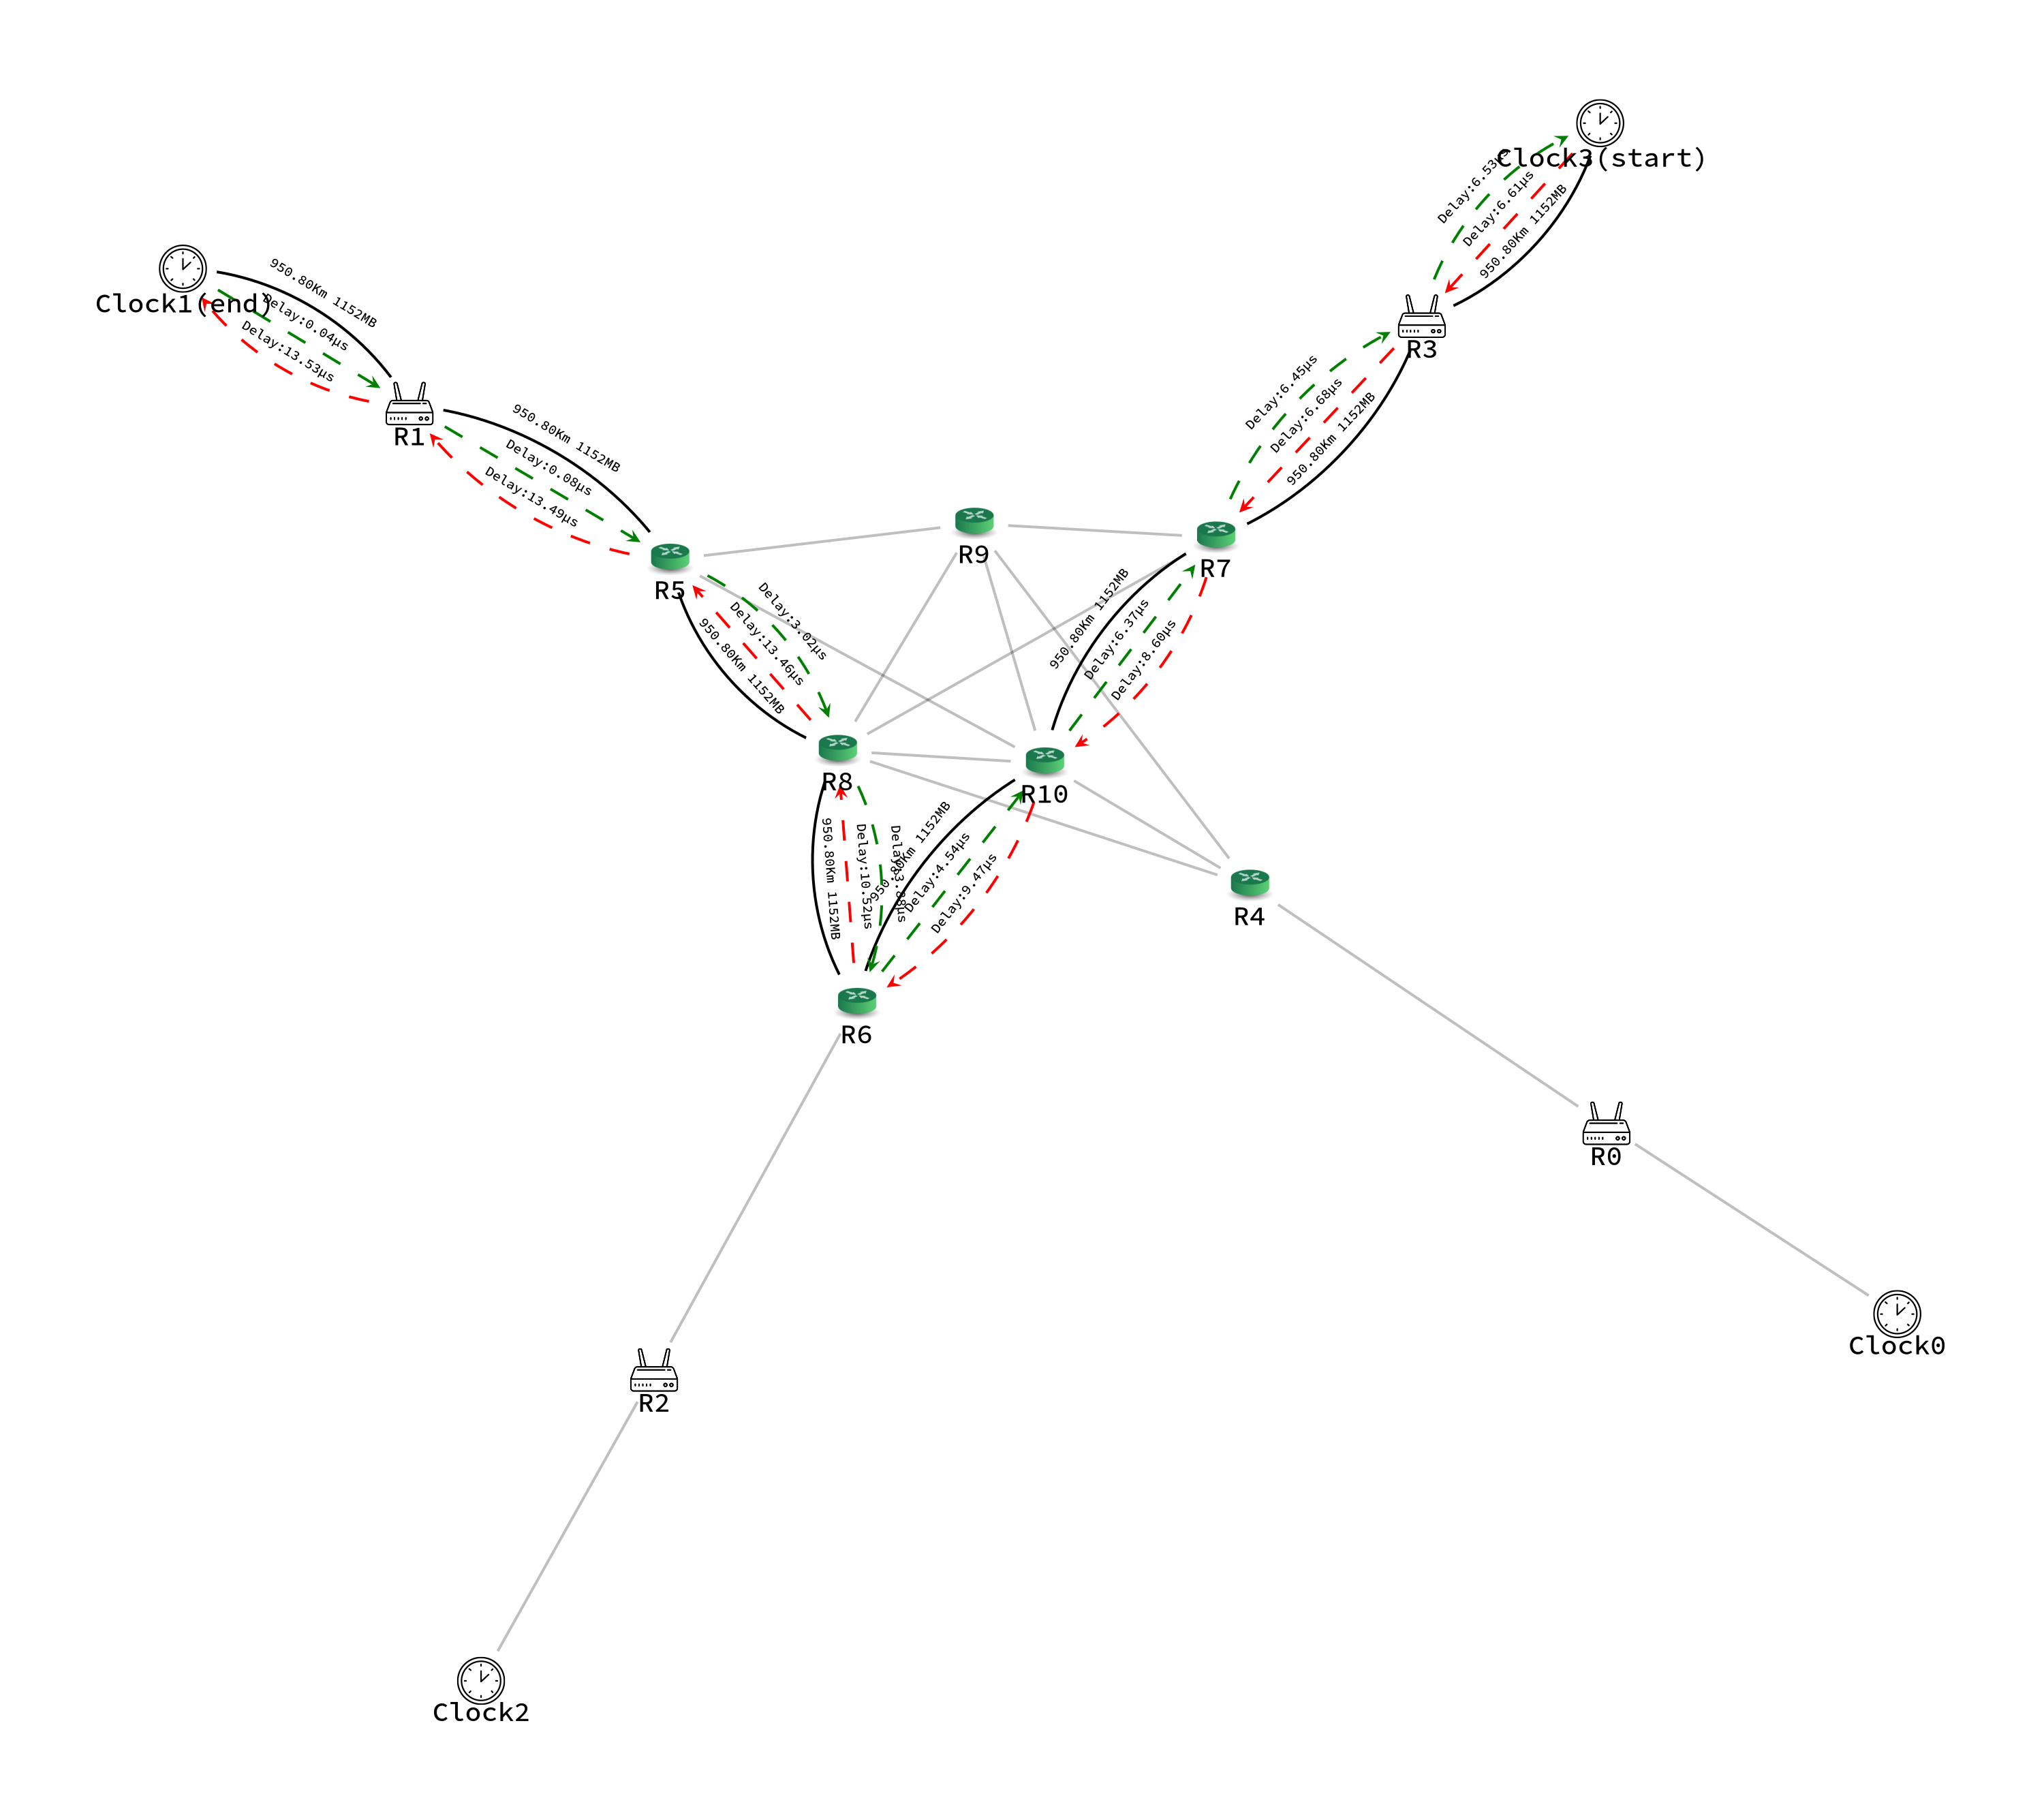

In [15]:
a = graph_draw(g
               ,pos=g_pos
               ,eorder=g_eorder
               ,vertex_text=g_v_label
               ,output_size=(1500,1500)
               ,bg_color="white"
               ,vertex_surface=g_sfcs
               ,vertex_size=g_v_size
               ,vertex_color=g_v_color
               ,vertex_fill_color=g_v_fill_color
               ,vertex_halo=g_v_halo
               ,vertex_font_size=g_v_font_size
               ,vertex_halo_size=g_v_halo_size
               ,vertex_text_offset=g_v_text_offset
               ,vertex_text_position=g_v_text_position
               ,vertex_pen_width=g_v_pen_width
               ,edge_end_marker=g_e_end_mark
               ,edge_pen_width=g_e_pen_width
               ,edge_marker_size=g_e_marker_size
               ,edge_text=g_e_text
               ,edge_text_parallel=g_e_text_parallel
               ,edge_font_size=g_e_text_font_size
               ,edge_color=g_e_color
               ,edge_text_distance=g_e_text_distance
               ,edge_dash_style = g_e_dash_style
#                ,output=config.get('config', 'output') if config.get('config', 'output') != "" else None
              )